In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib
import LinearResponseVariationalBayes.ModelSensitivity as sens_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Load results from previous fit.

In [2]:
json_input_file = os.path.join('./iris_fits_for_nips/bnp_full_data_fit_alpha8.0_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param_saved = model.global_vb_params.get_free()
    kl_hessian_saved = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
#moment_model = gmm_utils.InterestingMoments(model)
#dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [4]:
# moment_model.set_moments_from_free_par(best_param)
# print(moment_model.moment_params)

In [5]:
model.prior_params['alpha'].set(np.array([8.0]))
print(model.prior_params)
model.objective.logger.print_every = 10
best_param, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    model.optimize_full(best_param_saved)
kl_hessian = model.objective.fun_free_hessian(best_param)


prior_params:
	alpha: [8.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]
Iter: 0	 RMSE: 7.714893743176455	 Objective: -337.20752722456876
Optimization terminated successfully.
         Current function value: -337.207527
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: -337.207527
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 0


In [6]:
alpha0 = model.prior_params['alpha'].get()[0]
print(alpha0)

8.0


# Define a perturbation in the logit v space.

In [7]:
# def log_phi(logit_v):
#     return - logit_v - np.log1p(np.exp(-logit_v))

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))

# Define a perturbation in the logit v space.

phi_center = 2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
# def log_phi(logit_v):
#     return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def log_phi(logit_v):
    return(sp.special.expit(logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))



0.6931471805599453


This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [8]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 10 * log_phi(logit_v) / log_phi_max


phi max:  2.717370405124736
log phi max:  0.9996646498695336


In [9]:
quad_maxiter = 200

In [10]:
prior_perturbation = fun_sens_lib.PriorPerturbation(
    model, rescaled_log_phi, logit_v_ub=8, logit_v_lb = -8, quad_maxiter = quad_maxiter)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)
prior_perturbation.objective.logger.print_every = 10

-2.079441541679836 1.936236507197625 -2.0821248162554524 1.9385325300641851


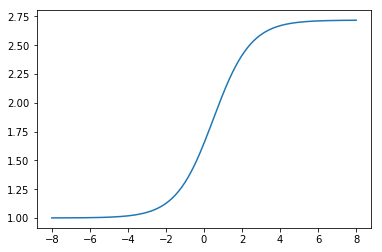

In [11]:
plt.plot(logit_v_grid, np.exp(log_phi(logit_v_grid)))

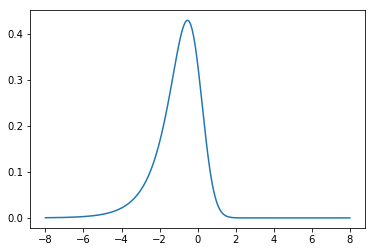

In [12]:
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))

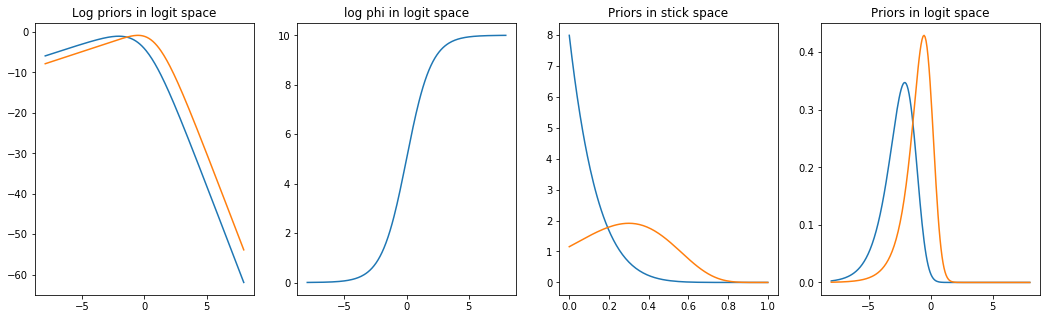

In [13]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


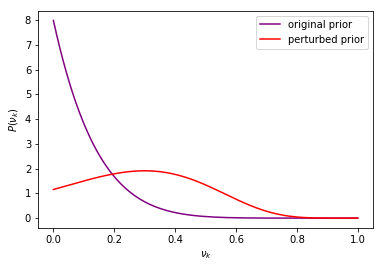

In [14]:
prior_perturbation.set_epsilon(1.0)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)), color = 'purple')
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)), color = 'red')
# plt.plot(v_grid, sp.stats.beta.pdf(v_grid, 1, 13), 'k--')

plt.ylabel('$P(\\nu_k)$')
plt.xlabel('$\\nu_k$')
plt.legend(('original prior', 'perturbed prior'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/perturbed_prior1_init3_5.png')

In [15]:
prior_plot_array = np.array([v_grid, 
                            np.exp(prior_perturbation.get_log_p0(v_grid)), 
                            np.exp(prior_perturbation.get_log_pc(v_grid))])

In [68]:
np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/prior_pert1.csv', 
          prior_plot_array, delimiter = ',')

# Choose the number of GH points.

In [17]:
# Sanity check the perturbation

# gmm_utils.set_gauss_hermite_points(
#     prior_perturbation.model.vb_params, gh_deg=10)
#
# prior_perturbation.set_epsilon(1.0)
# print(prior_perturbation.get_e_log_perturbation(sum_vector=False))
#
# prior_perturbation.set_epsilon(0.5)
# print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

prior_perturbation.set_epsilon(1.0)

gmm_utils.set_gauss_hermite_points(
    prior_perturbation.model.vb_params, gh_deg=1)
print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

gmm_utils.set_gauss_hermite_points(
    prior_perturbation.model.vb_params, gh_deg=2)
print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

gmm_utils.set_gauss_hermite_points(
    prior_perturbation.model.vb_params, gh_deg=10)
print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

[-3.19735565 -4.27427267 -6.58469451 -0.41087037 -0.55233363 -4.8926834
 -1.25929633 -0.9095254  -0.88194453 -0.85902237 -0.83950095 -0.8225166
 -0.80745349 -0.79389803 -0.78169019 -0.77098316 -0.76197276 -0.75455785
 -0.74851958 -0.74368134 -0.73987291 -0.73690609 -0.73459714 -0.73279085
 -0.73136702 -0.7302358  -0.72933039 -0.7286007  -0.7280088 ]
[-3.20870957 -4.28096385 -6.55965111 -0.57037267 -0.71820901 -4.89773405
 -1.53978934 -1.21981641 -1.20193139 -1.18736077 -1.1750185  -1.16417758
 -1.15433505 -1.14517355 -1.13662029 -1.12891766 -1.12235865 -1.11693788
 -1.11252073 -1.10900247 -1.10627353 -1.10419517 -1.10262257 -1.10143067
 -1.1005226  -1.0998267  -1.0992905  -1.09887533 -1.09855241]
[-3.20862258 -4.28088452 -6.56013301 -0.57777346 -0.72171868 -4.89745513
 -1.52546743 -1.20952378 -1.19155312 -1.17693363 -1.16458155 -1.15377187
 -1.14400304 -1.13495701 -1.12655351 -1.11901535 -1.11261296 -1.10733116
 -1.10303293 -1.09961173 -1.09695796 -1.09493542 -1.0934032  -1.09224007
 -

In [18]:
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

prior_perturbation.set_epsilon(1.0)

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(
        prior_perturbation.model.vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        prior_perturbation.get_e_log_perturbation(sum_vector=False))

print(expected_perturbations_list[0])
print(expected_perturbations_list[1])
expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1)
print(max_diffs)
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_list[gh_deg_threshold])
print('Chosen gh_dg = {}, learned threshold = {}, checked_points = {}'
      .format(gh_deg, gh_deg_list[gh_deg_threshold], len(max_diffs)))

[-3.20862181 -4.28088333 -6.56014419 -0.57965744 -0.72320918 -4.89743505
 -1.52621733 -1.21258776 -1.19506002 -1.18085629 -1.16889274 -1.15844494
 -1.14901239 -1.14027789 -1.13216017 -1.12487751 -1.11869581 -1.11360057
 -1.1094581  -1.10616508 -1.10361536 -1.10167668 -1.10021207 -1.0991037
 -1.0982605  -1.09761527 -1.09711884 -1.09673503 -1.09643698]
[-3.20862259 -4.28088455 -6.56013272 -0.5777613  -0.72163392 -4.89745684
 -1.52501913 -1.20856292 -1.19044961 -1.17569417 -1.1632141  -1.15228531
 -1.14240682 -1.13326095 -1.12476787 -1.11715109 -1.11068138 -1.10534286
 -1.10099729 -1.09753697 -1.09485109 -1.09280225 -1.09124844 -1.09006751
 -1.08916493 -1.08847077 -1.0879338  -1.08751623 -1.08718989]
[8.50550858e-03 2.32602805e-03 2.30334156e-04 1.06571831e-04
 7.54203241e-05 2.72504590e-05 5.40528556e-06 8.36654613e-07
 1.49083544e-06 9.08754727e-07 3.84123941e-07 1.07936841e-07
 1.89115868e-09 2.39151123e-08 2.11205540e-08 1.26661847e-08
 5.93974436e-09 2.05828945e-09 2.73909897e-10 3.3

In [19]:
# First fit with no perturbation but the increased number of gh points.

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)
model.objective.logger.initialize()

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 7.71489372333978	 Objective: -337.2075482609857
Optimization terminated successfully.
         Current function value: -337.207548
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: -337.207548
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. 


# Examine Fit 

In [20]:
pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)

In [21]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [22]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(
        pca_fit, bnp_centroids, bnp_cluster_covs)

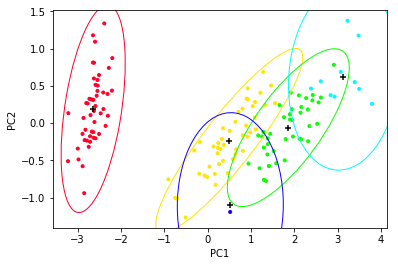

In [23]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

# plt.savefig('../../../writing/functional_sensitivity_writing/parametric_sens_results/init_fit_alph8.0.png')

# Define prior perturbation

In [24]:
# This expects the hyperparameter to be at its optimal value.
prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    sens_lib.ParametricSensitivityLinearApproximation(
        objective_functor=prior_perturbation.get_perturbed_kl,
        input_par=prior_perturbation.model.global_vb_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_val0=best_param_0,
        hyper_val0=np.array([0.0]),
        input_is_free=True,
        hyper_is_free=False,
        hyper_par_objective_functor=prior_perturbation.get_e_log_perturbation)

# epsilon_sensitivity = \
#     obj_lib.ParametricSensitivity(
#         objective_fun=model.set_z_get_kl,
#         input_par=prior_perturbation.model.global_vb_params,
#         output_par=moment_model.moment_params,
#         hyper_par=prior_perturbation.epsilon_param,
#         input_to_output_converter=moment_model.set_moments,
#         optimal_input_par=best_param_0,
#         objective_hessian=kl_hessian_0,
#         hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [25]:
prior_perturbation.set_epsilon(0.0)
print(prior_perturbation.get_e_log_perturbation())

prior_perturbation.set_epsilon(1.0)
print(prior_perturbation.get_e_log_perturbation())

print(np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper()))

-0.0
-46.4448387985173
6.189662874977386


## Fit with perturbation

In [26]:
epsilon = 1.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
# output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
#     epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  1.0
Predicted differences:  6.189662874977386


In [27]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)


best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)

# output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
# output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

epsilon: 1.0
Iter  0  value:  -402.8133563138003
Optimization terminated successfully.
         Current function value: -404.768417
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: -404.768417
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 8.237861904625534


Epsilon: 1.0


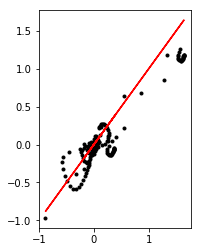

In [28]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

# plt.subplot(1, 2, 2)
# plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
# plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [29]:
print('original expected number of clusters: ',
      gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_0, model))

print('perturbed expected number of clusters: ',
      gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi, model))

print('predicted expected number of clusters: ',
      gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi_pred, model))

original expected number of clusters:  11.004715673911797
perturbed expected number of clusters:  8.422602070700913
predicted expected number of clusters:  8.218380958348769


In [30]:
def get_stick_result(free_par, model):
    model.global_vb_params.set_free(free_par)
    return np.vstack(
        [1 / np.sqrt(model.global_vb_params['v_sticks']['info'].get()), \
         model.global_vb_params['v_sticks']['mean'].get() ])


In [31]:
og_stick_means = get_stick_result(best_param_0, model)[0]
pert_stick_means = get_stick_result(best_param_phi, model)[0]
lr_stick_means = get_stick_result(best_param_phi_pred, model)[0]

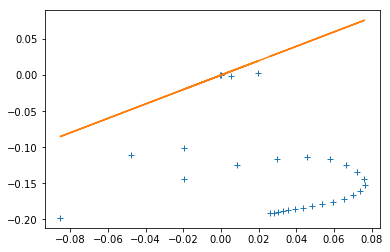

In [32]:
plt.plot(lr_stick_means - og_stick_means, pert_stick_means - og_stick_means, '+')
plt.plot(lr_stick_means - og_stick_means, lr_stick_means - og_stick_means, '-')


In [33]:
og_stick_vars = get_stick_result(best_param_0, model)[1]
pert_stick_vars = get_stick_result(best_param_phi, model)[1]
lr_stick_vars = get_stick_result(best_param_phi_pred, model)[1]

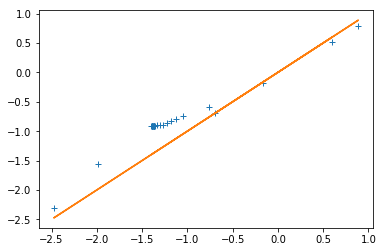

In [34]:
plt.plot(lr_stick_vars, pert_stick_vars, '+')
plt.plot(lr_stick_vars, lr_stick_vars, '-')

# Predict for a range of perturbations

In [35]:
#epsilon_vec = np.append(np.linspace(0, 0.1, 6), np.linspace(0.2, 1.0, 6))
epsilon_vec = np.linspace(0, 1, 11) ** 2 # Square to get more points close to 0
# epsilon_vec = -np.linspace(0, 10, 11)
print(epsilon_vec)

[0.   0.01 0.04 0.09 0.16 0.25 0.36 0.49 0.64 0.81 1.  ]


In [36]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

prior_perturbation.objective.logger.print_every = 10

for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    best_param_phi_pred = \
        epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
    output_phi_pred = \
        gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi_pred, model)
    
#     epsilon_sensitivity.predict_output_par_from_hyperparameters(
#         epsilon, linear=True)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    
    # Then fit with the perturbation.
    prior_perturbation.objective.logger.initialize()
    prior_perturbation.set_epsilon(epsilon_vec[i])
    print(prior_perturbation.epsilon_param)
    best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        opt_lib.repeatedly_optimize(
            objective=prior_perturbation.objective,
            optimization_fun=
                lambda x: gmm_utils.precondition_and_optimize(
                    prior_perturbation.objective, x),
            init_x=best_param_phi_pred,
            initial_optimization_fun=None,
            keep_intermediate_optimizations=True)

#     output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
    output_phi = \
        gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi, model)

    print('Done. Converged: ', converged)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    print('Actual differences: (This is nonzero if phi did anything):',
          np.linalg.norm(best_param_phi - best_param_0))
    
    # save results: 
    best_param_phi_array.append(best_param_phi)
    best_param_phi_pred_array.append(best_param_phi_pred)
    
    output_phi_array.append(output_phi)
    output_phi_pred_array.append(output_phi_pred)
    



Epsilon:  0.0
Predicted differences:  0.0
epsilon: 0.0
Optimization terminated successfully.
Iter  0  value:  -337.20754826806717
         Current function value: -337.207548
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.0
Actual differences: (This is nonzero if phi did anything): 1.2654753550255434e-14


Epsilon:  0.010000000000000002
Predicted differences:  0.06189662874977398
epsilon: 0.010000000000000002
Iter  0  value:  -337.6733881702504
Optimization terminated successfully.
         Current function value: -337.673388
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: -337.673388
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  

In [42]:
# np.save('best_param_phi_array', best_param_phi_array)

In [43]:
# output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)
output_0 = \
    gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_0, model)


In [44]:
# for i in range(len(epsilon_vec)): 
#     plt.figure(figsize=(8, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_pred_array[i] - best_param_0, 'k.')
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_array[i] - best_param_0, 'r')
#     plt.xlabel('true diff global free params')
#     plt.ylabel('pred diff global free params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))

#     plt.subplot(1, 2, 2)
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_pred_array[i] - output_0, 'k.')
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_array[i] - output_0, 'r')
#     plt.xlabel('true diff moment params')
#     plt.ylabel('pred diff moment params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
#     plt.tight_layout()

    

# Lets also look at the expected number of clusters

In [45]:
# # This expects the hyperparameter to be at its optimal value.
# #e_num_clusters_class = gmm_utils.ExpectedNumClustersFromZ(model)
# #e_num_clusters_class = gmm_utils.ExpectedNumClustersFromLogitSticks(model)
# e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

# prior_perturbation.set_epsilon(0.0)
# cluster_sensitivity = \
#     obj_lib.ParametricSensitivity(
#         objective_fun=model.set_z_get_kl,
#         input_par=e_num_clusters_class.model.global_vb_params,
#         output_par=e_num_clusters_class.e_num_clusters,
#         hyper_par=prior_perturbation.epsilon_param,
#         input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
#         optimal_input_par=best_param_0,
#         objective_hessian=kl_hessian_0,
#         hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [46]:
e_num_heavy_clusters_class = gmm_utils.ExpectedNumClustersFromZ(model)
e_num_pred_heavy_clusters_class = gmm_utils.ExpectedPredNumClusters(model)

In [47]:
from tqdm import tqdm

In [63]:
threshold = 0

In [64]:
e_num_clusters_pred = []
e_num_clusters_true = []

e_num_clusters_true_var = []
e_num_clusters_pred_var = []

for i in tqdm(range(len(epsilon_vec))):
    # predicted quantities
    pred_mean, pred_var = e_num_heavy_clusters_class.get_e_num_heavy_clusters_from_free_par(
            best_param_phi_pred_array[i], threshold = threshold)
    
    # refitted quantities
    refit_mean, refit_var = e_num_heavy_clusters_class.get_e_num_heavy_clusters_from_free_par(
            best_param_phi_array[i], threshold = threshold)
    
    e_num_clusters_pred.append(pred_mean)
    e_num_clusters_true.append(refit_mean)
    
    e_num_clusters_pred_var.append(pred_var)
    e_num_clusters_true_var.append(refit_var)

    

100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


In [65]:
e_num_post_pred_clusters_pred = []
e_num_post_pred_clusters_true = []
for i in tqdm(range(len(epsilon_vec))):
    e_num_post_pred_clusters_pred.append(
        e_num_pred_heavy_clusters_class.get_e_num_pred_heavy_clusters_from_free_par(
            best_param_phi_pred_array[i], threshold = threshold))
    e_num_post_pred_clusters_true.append(
        e_num_pred_heavy_clusters_class.get_e_num_pred_heavy_clusters_from_free_par(
            best_param_phi_array[i], threshold = threshold))

100%|██████████| 11/11 [00:01<00:00,  8.25it/s]


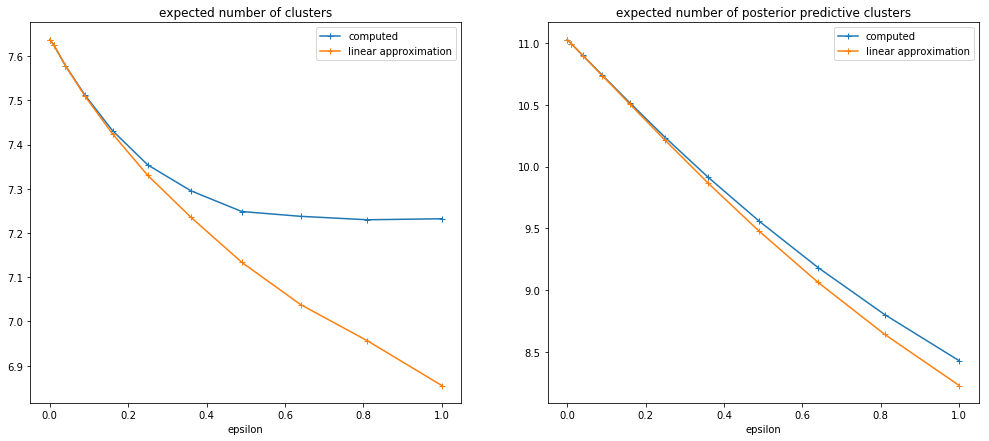

In [66]:
plt.figure(figsize=(17, 7))

plt.subplot(121)
plt.plot(epsilon_vec, e_num_clusters_true, '+-')
plt.plot(epsilon_vec, e_num_clusters_pred, '+-')
plt.xlabel('epsilon')
plt.title('expected number of clusters')
plt.legend(('computed', 'linear approximation'))

plt.subplot(122)
plt.plot(epsilon_vec, e_num_post_pred_clusters_true, '+-')
plt.plot(epsilon_vec, e_num_post_pred_clusters_pred, '+-')
plt.xlabel('epsilon')
plt.title('expected number of posterior predictive clusters')
plt.legend(('computed', 'linear approximation'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/pred_num_clusters1_init3_5.png')

In [67]:
func_sens_results_array = np.array([epsilon_vec, 
                                   np.array(e_num_clusters_true).squeeze(), 
                                   np.array(e_num_clusters_pred).squeeze()])

np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/prior_pert1_enum_clust_results.csv', 
        func_sens_results_array, 
          delimiter = ',')

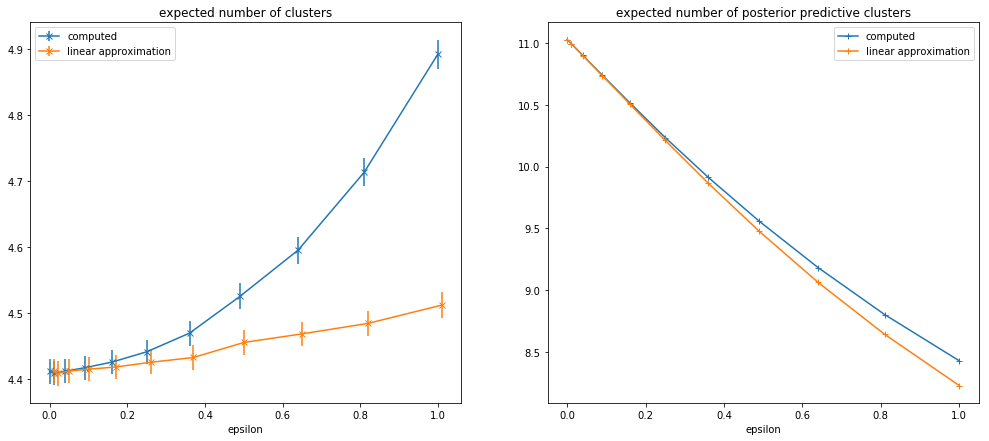

In [61]:
plt.figure(figsize=(17, 7))

plt.subplot(121)
plt.errorbar(epsilon_vec, e_num_clusters_true, yerr=3 * np.sqrt(e_num_clusters_true_var) / np.sqrt(10000), fmt = 'x-')
plt.errorbar(epsilon_vec + 0.01, e_num_clusters_pred, yerr= 3 * np.sqrt(e_num_clusters_pred_var) / np.sqrt(10000), 
             fmt = 'x-')
plt.xlabel('epsilon')
plt.title('expected number of clusters')
plt.legend(('computed', 'linear approximation'))

plt.subplot(122)
plt.plot(epsilon_vec, e_num_post_pred_clusters_true, '+-')
plt.plot(epsilon_vec, e_num_post_pred_clusters_pred, '+-')
plt.xlabel('epsilon')
plt.title('expected number of posterior predictive clusters')
plt.legend(('computed', 'linear approximation'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/pred_num_clusters1_init3_5.png')

(11, 2, 29)


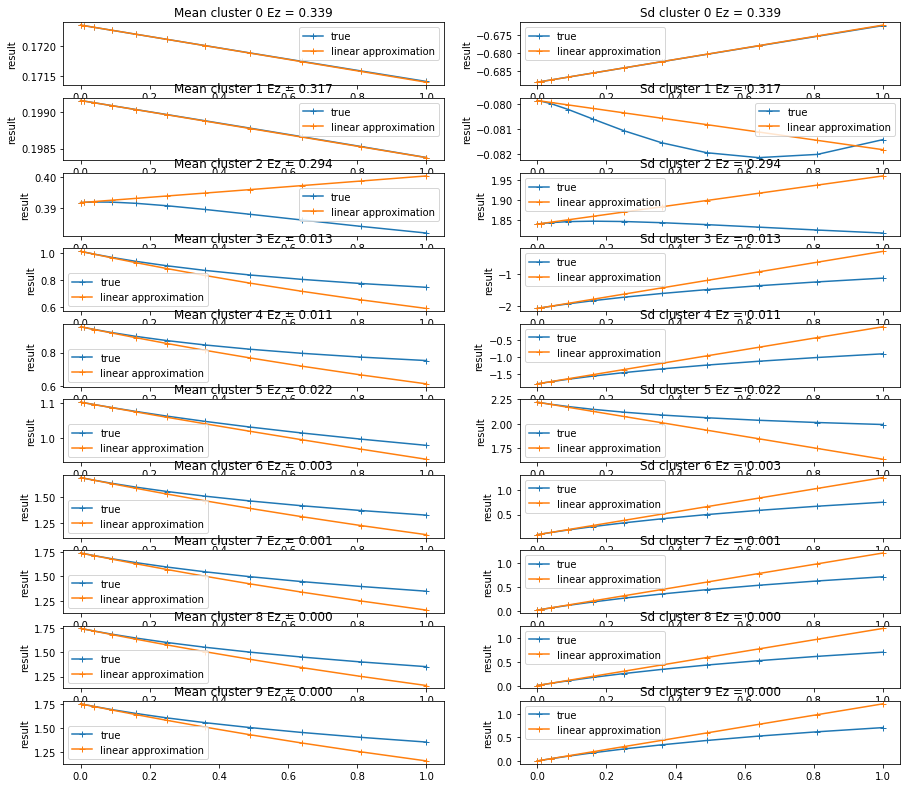

In [60]:
# Look at stick quantities.

cluster_probs = model.get_e_cluster_probabilities()

def get_stick_result(free_par, model):
    model.global_vb_params.set_free(free_par)
    return np.vstack(
        [1 / np.sqrt(model.global_vb_params['v_sticks']['info'].get()), \
         model.global_vb_params['v_sticks']['mean'].get() ])

sticks_true = np.array([ get_stick_result(free_par, model) for free_par in best_param_phi_array ])
sticks_pred = np.array([ get_stick_result(free_par, model) for free_par in best_param_phi_pred_array ])

plt.figure(figsize=(15, 40))
print(sticks_true.shape)
for k in range(model.k_approx - 20):
    plt.subplot(model.k_approx - 1, 2, 2 * k + 1)
    plt.plot(epsilon_vec, sticks_true[:, 0, k], '+-')
    plt.plot(epsilon_vec, sticks_pred[:, 0, k], '+-')
    #plt.xlabel('epsilon')
    plt.ylabel('result')
    plt.title('Mean cluster {0} Ez = {1:0.3f}'.format(k, cluster_probs[k]))
    plt.legend(('true', 'linear approximation'))

    plt.subplot(model.k_approx - 1, 2, 2 * k + 2)
    plt.plot(epsilon_vec, sticks_true[:, 1, k], '+-')
    plt.plot(epsilon_vec, sticks_pred[:, 1, k], '+-')
    #plt.xlabel('epsilon')
    plt.ylabel('result')
    plt.title('Sd cluster {0} Ez = {1:0.3f}'.format(k, cluster_probs[k]))
    plt.legend(('true', 'linear approximation'))

# k = 1
# plt.plot(epsilon_vec, sticks_true[:, k, 0], '+-')
# plt.plot(epsilon_vec, sticks_pred[:, k, 0], '+-')
# plt.xlabel('epsilon')
# plt.ylabel('result')
# plt.legend(('true', 'linear approximation'))


[3.35526254e-01 3.19104489e-01 2.95765234e-01 7.36511011e-03
 7.53990961e-03 2.98979426e-02 2.46799567e-03 1.17124470e-03
 5.81464514e-04 2.90263284e-04 1.45061384e-04 7.25187125e-05
 3.62572001e-05 1.81282020e-05 9.06402595e-06 4.53199839e-06
 2.26599620e-06 1.13299744e-06 5.66498576e-07 2.83249258e-07
 1.41624623e-07 7.08123110e-08 3.54061554e-08 1.77030777e-08
 8.85153886e-09 4.42576943e-09 2.21288472e-09 1.10644236e-09
 5.53221179e-10 5.53221179e-10]


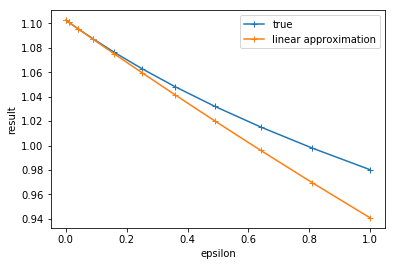

In [36]:
# Look at generic quantities.


model.global_vb_params.set_free(best_param_0)
print(model.get_e_cluster_probabilities())

stick_ind = 5
def get_result(free_par, model):
    model.global_vb_params.set_free(free_par)
    return 1 / np.sqrt(model.global_vb_params['v_sticks']['info'].get()[stick_ind])
    #return model.global_vb_params['v_sticks']['mean'].get()[stick_ind]

result_pred = []
result_true = []
for i in range(len(epsilon_vec)):
    result_pred.append(get_result(best_param_phi_pred_array[i], model))
    result_true.append(get_result(best_param_phi_array[i], model))

    
plt.plot(epsilon_vec, result_true, '+-')
plt.plot(epsilon_vec, result_pred, '+-')
plt.xlabel('epsilon')
plt.ylabel('result')
plt.legend(('true', 'linear approximation'))


In [37]:
np.array(e_num_clusters_true)

array([4.78326842, 4.79240423, 4.81926075, 4.86223316, 4.91888963,
       4.98634457, 5.06157844, 5.14158614, 5.22339057, 5.30402966,
       5.38064906])

In [38]:
func_sens_results_array = np.array([epsilon_vec, 
                                   np.array(e_num_clusters_true).squeeze(), 
                                   np.array(e_num_clusters_pred).squeeze()])

# np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/prior_pert2_enum_clust_results.csv', 
#         func_sens_results_array, 
#           delimiter = ',')

In [47]:
def plot_results_from_free_params(model, global_free_params, fig): 
    # look at results
    model.global_vb_params.set_free(global_free_params)
    model.set_optimal_z()

    bnp_clusters = np.argmax(model.e_z, axis = 1)
    bnp_centroids = model.vb_params['global']['centroids'].get()

    bnp_cluster_infos = model.vb_params['global']['gamma'].get()
    bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)
    
    pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)
    
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
        
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')


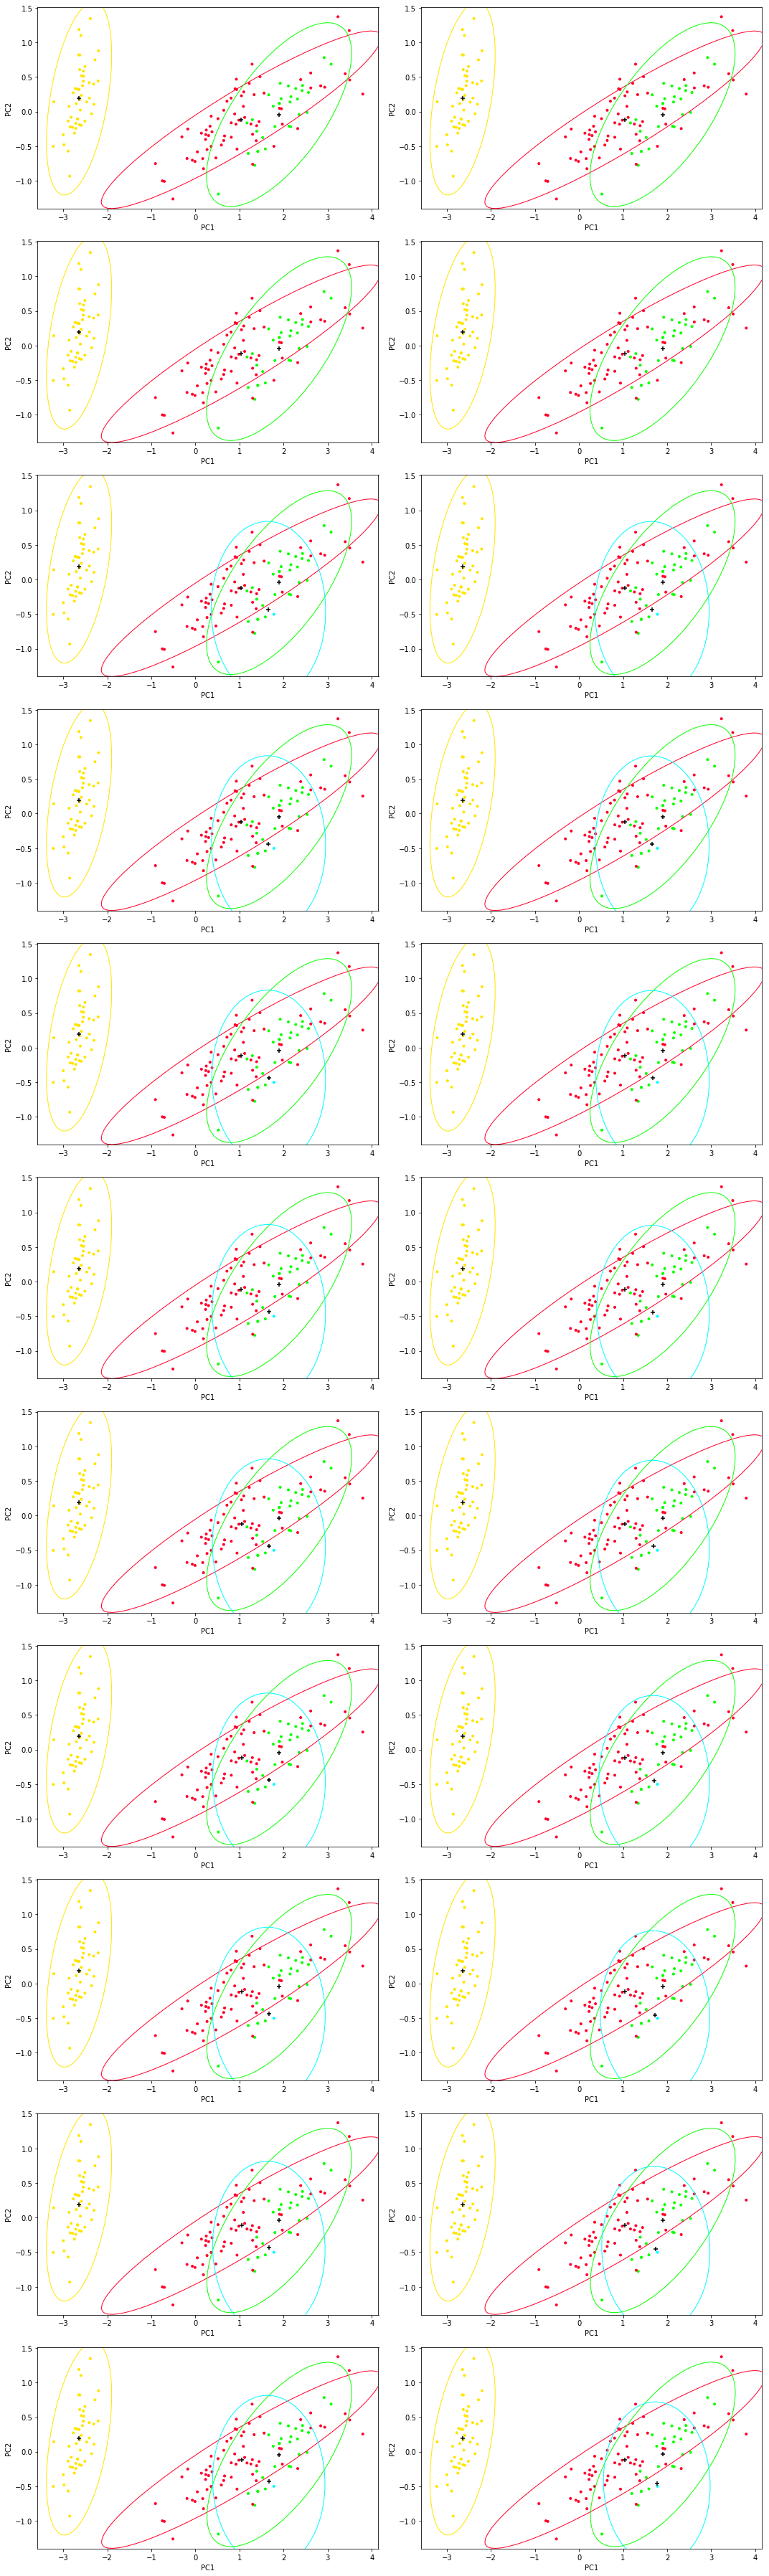

In [48]:
f, axarr = plt.subplots(len(epsilon_vec), 2, figsize = (15, 50))

for i in range(len(epsilon_vec)): 
    plot_results_from_free_params(model, best_param_phi_array[i], axarr[i, 0])
    plot_results_from_free_params(model, best_param_phi_pred_array[i], axarr[i, 1])

f.tight_layout()